# Mall Customers

## notebook

* Acquire data from mall_customers.customers in mysql database.
* Summarize data (include distributions and descriptive statistics).
* Detect outliers using IQR.
* Split data (train, validate, and test split).
* Encode categorical columns using a one hot encoder (pd.get_dummies).
* Handles missing values.
* Scaling

In [1]:
from env import user, host, password
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
import sklearn.preprocessing

import warnings
warnings.filterwarnings("ignore")

# Acquire data from mall_customers.customers in mysql database.

In [2]:
df = pd.read_csv('mall_customers_query.csv')

# Summarize data (include distributions and descriptive statistics).

In [3]:
df.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Dropping customer_id becuase no information is heald in this column

In [4]:
# drop customer ID
df = df[['gender', 'age', 'annual_income', 'spending_score']]
df.head()

,gender,age,annual_income,spending_score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [6]:
df.describe()

,age,annual_income,spending_score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [7]:
df.shape

(200, 4)

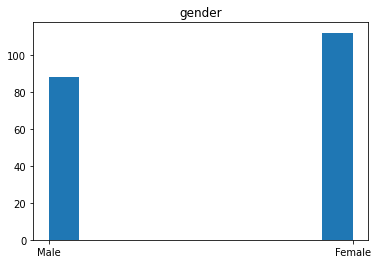

In [8]:
# distribution of the data
num_cols = [col for col in df.columns if df[col].dtype == 'object']

for col in num_cols:
    plt.hist(df[col])
    plt.title(col)
    plt.show()
    

Sharp drop off in customer count at 90K income.

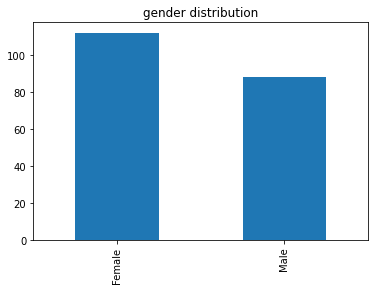

In [9]:
# vis 
num_cols = [col for col in df.columns if df[col].dtype == 'object']

for col in num_cols:
    
    df[f'{col}'].value_counts().plot(kind='bar', title = f"{col} distribution")

Slightly more female customers then male customers.

# Detect outliers using IQR.

In [10]:
num_cols = [col for col in df.columns if df[col].dtype == 'int64']

k = 1.5

for col in num_cols:
    
    q1, q3 = df[f'{col}'].quantile([.25, .75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr
    lower_bound = q1 - k * iqr
    
    print(f"{col}: lower_bound = {lower_bound} upper_bound = {upper_bound}")
    
    df = df[(df[f'{col}'] > lower_bound) & (df[f'{col}'] < upper_bound)]

age: lower_bound = -1.625 upper_bound = 79.375
annual_income: lower_bound = -13.25 upper_bound = 132.75
spending_score: lower_bound = -21.625 upper_bound = 129.375


In [11]:
df.head()

,gender,age,annual_income,spending_score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [12]:
df.shape

(198, 4)

# Split data (train, validate, and test split).

In [13]:
train, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train, test_size=.3, random_state=123)

In [14]:
print(train.shape, validate.shape , test.shape)

(110, 4) (48, 4) (40, 4)


# Encode categorical columns using a one hot encoder (pd.get_dummies).

In [15]:
num_cols = [col for col in df.columns if df[col].dtype == 'object']

for col in num_cols:

    dummies = pd.get_dummies(df[f'{col}'], drop_first=True) 

    df = pd.concat([df, dummies], axis=1)

In [16]:
df.head()

,gender,age,annual_income,spending_score,Male
0,Male,19,15,39,1
1,Male,21,15,81,1
2,Female,20,16,6,0
3,Female,23,16,77,0
4,Female,31,17,40,0


# Handles missing values.

In [17]:
df.isna().sum() # number of missing values

gender            0
age               0
annual_income     0
spending_score    0
Male              0
dtype: int64

# Scaling

In [18]:
train.shape

(110, 4)

In [19]:
train = train.reset_index(drop=True)
train.head()

,gender,age,annual_income,spending_score
0,Female,24,39,65
1,Female,20,37,75
2,Female,35,19,99
3,Male,28,87,75
4,Male,24,60,52


In [20]:
num_cols = [col for col in df.columns if df[col].dtype == 'int64']

scaler = sklearn.preprocessing.MinMaxScaler() # create scaler object

scaler.fit(train[num_cols]) # fit the object 

train_scaled = pd.DataFrame(scaler.transform(train[num_cols]), columns = train[num_cols].columns + "_scaled")

validate_scaled = pd.DataFrame(scaler.transform(validate[num_cols]), columns = validate[num_cols].columns)
test_scaled = pd.DataFrame(scaler.transform(test[num_cols]), columns = test[num_cols].columns)

In [21]:
train_scaled.shape

(110, 3)

In [22]:
train = train.merge(train_scaled, left_index=True, right_index=True)

In [23]:
train.head(10)

,gender,age,annual_income,spending_score,age_scaled,annual_income_scaled,spending_score_scaled
0,Female,24,39,65,0.115385,0.216216,0.653061
1,Female,20,37,75,0.038462,0.198198,0.755102
2,Female,35,19,99,0.326923,0.036036,1.000000
3,Male,28,87,75,0.192308,0.648649,0.755102
4,Male,24,60,52,0.115385,0.405405,0.520408
5,Female,46,25,5,0.538462,0.090090,0.040816
6,Male,42,86,20,0.461538,0.639640,0.193878
7,Male,20,21,66,0.038462,0.054054,0.663265
8,Male,25,77,12,0.134615,0.558559,0.112245
9,Male,20,73,5,0.038462,0.522523,0.040816


In [24]:
train_scaled.shape

(110, 3)

In [25]:
train.shape

(110, 7)

In [26]:
train.dropna()


,gender,age,annual_income,spending_score,age_scaled,annual_income_scaled,spending_score_scaled
0,Female,24,39,65,0.115385,0.216216,0.653061
1,Female,20,37,75,0.038462,0.198198,0.755102
2,Female,35,19,99,0.326923,0.036036,1.000000
3,Male,28,87,75,0.192308,0.648649,0.755102
4,Male,24,60,52,0.115385,0.405405,0.520408
...,...,...,...,...,...,...,...
105,Male,57,54,51,0.750000,0.351351,0.510204
106,Male,38,71,75,0.384615,0.504505,0.755102
107,Female,57,75,5,0.750000,0.540541,0.040816
108,Female,29,73,88,0.211538,0.522523,0.887755


In [27]:
train[num_cols].columns + "_scaled"

Index(['age_scaled', 'annual_income_scaled', 'spending_score_scaled'], dtype='object')